# Solving the Max-Clique Problem

In this notebook, we will describe how to solve the **Max-Clique** problem with LunaSolve. We will begin by defining, explaining and giving an example for the Max-Clique problem. We will then continue by modeling a problem instance and optimize and implement the solution using LunaSolve. Finally, we will also take a further look at the interpretation of the answer we are returned from Luna.


## Table of Contents

1. [Introduction](#1)
2. [Real World Example](#2)
3. [Solving the Max-Clique Problem with Luna](#3)



<a id="1"></a>
## 1. Introduction

## **Max-Clique** 
The Max-Clique problem is a combinatorial optimization problem in graph theory where the goal is to find the largest clique. A Clique is a subset of vertices in a graph where every pair of vertices is connected by an edge. Intuitively, it is about identifying the largest fully connected subgraph of the graph. 

However the Max-Clique problem can also be expressed more precisely. Formally, a clique in an undirected graph $G = (V, E)$, with vertices $V$ and connecting edges $E$, is a subset of vertices $C \subseteq V$ such that for every pair of vertices $u, v \in C$, the edge $(u,v)$ is in $E$. Then the objective of the Max-Clique problem asks to find a clique of maximum size in $G$.


<a id="2"></a>
## 2. Description

To better illustrate the Max-Clique problem consider the following example. Imagine you're planning a small board games night. You want to create an enjoyable and harmonious atmosphere with a not too large group of friends. So you decide to invite a group of friends who all know and get along with one another, from your various social circles. However the games are more fun the more participate, so you choose from all of your friends. The challenge you are facing is to identify the largest group from your social circle, such that everyone gets along well.

You have the following information about your friends **Alice (A)**, **Bob (B)**, **Charlie (C)**, **David (D)**, **Emma (E)**, **Frank (F)**, **Grace (G)**, **Henry (H)**, **Irene (I)**, **Jade (J)**, and **Ken (K)**.

- A knows B, C, and D.  
- B knows A, C, and D.  
- C knows A, B, and D.  
- D knows A, B, C, and E.  
- E knows F, D, J, I and K.  
- F knows E.  
- G knows H and I.  
- H knows G and I.  
- I knows G and H.  
- J knows E and K.  
- K knows E and J.

The relationship of these relationships can be represented as a network or a graph and will also improve the visualisation of our problem at hand.


<a id="3"></a>
## 3. Solving the Max-Clique problem with Luna

To follow along with the next steps, three libraries are needed:
1. **luna-quantum** for encoding and solving our optimization problem,  
2. **matplotlib** for visualization, and  
3. **networkx** for creating and drawing the graph.  

The cell below installs these packages for you if they are not already installed.

In [1]:
# Install dependencies
%pip install --upgrade pip
%pip install luna-quantum --upgrade
%pip install matplotlib networkx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 3.1 Set up Luna Client

Now, let's walk through the implementation of the Max-Clique problem using LunaSolve. First, create an encryption key. You can generate a key [here](https://docs.aqarios.com/get-started#luna-encryption).

In [2]:
import os
os.environ["LUNA_ENCRYPTION_KEY"] = "gzaUL8hDECWXRcGrJiEa5wVWVgt4sgPbBDjKN8I92ps"

As the next step, instantiate a LunaSolve object and set your credentials. The API key is needed to identify you and grant access to the Luna platform. You can find it in your Aqarios account settings.

In [3]:
from luna_sdk import LunaSolve
ls = LunaSolve(api_key="60360df4e8b54305aababfa6ac99429e")

### 3.2 Create a Max-Clique problem

To create a Max-Clique instance, any graph with vertices and edges is sufficient. In this notebook, we will create one representing the network of friendships among 11 of our friends, labeled from 0 to 10. Each person is a node of the graph. Some pairs of our friends are also friends, and we express this attribute through an edge connecting the two nodes representing them. 

After defining the graph, we will visualize it for better comprehension.

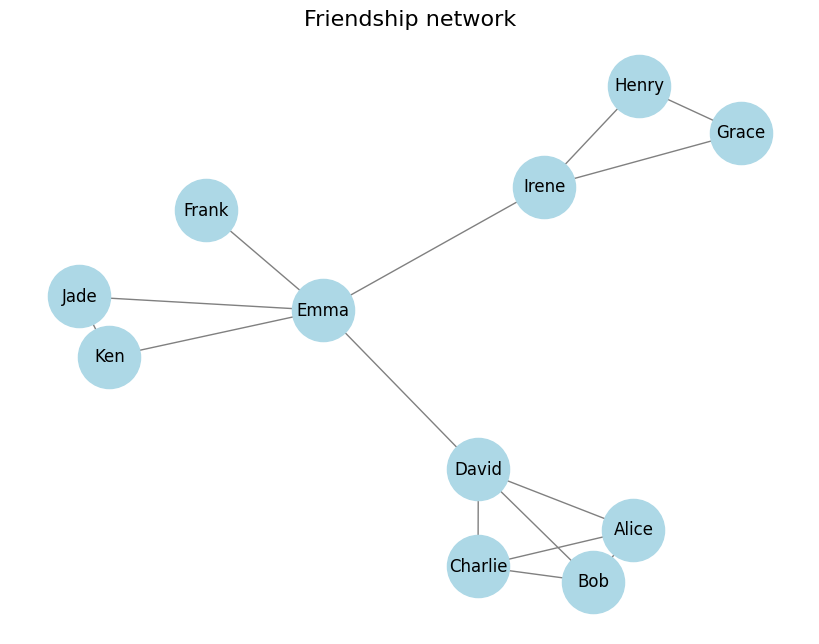

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
max_clique_graph = nx.Graph()

# Add nodes (people)
people = [
    "Alice", "Bob", "Charlie", "David", "Emma", "Frank",
    "Grace", "Henry", "Irene", "Jade", "Ken"
]
max_clique_graph.add_nodes_from(people)

# Add edges (relationships)
relationships = [
    ("Alice", "Bob"),
    ("Alice", "Charlie"),
    ("Alice", "David"),
    ("Bob", "Charlie"),
    ("Bob", "David"),
    ("Charlie", "David"),
    
    ("Emma", "David"),
    ("Emma", "Frank"),
    ("Emma", "Irene"),
    
    ("Grace", "Henry"),
    ("Henry", "Irene"),
    ("Irene", "Grace"),
    
    ("Emma", "Jade"),
    ("Jade", "Ken"),
    ("Ken", "Emma")
]

max_clique_graph.add_edges_from(relationships)

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(max_clique_graph)
nx.draw(
    max_clique_graph, pos, with_labels=True, node_size=2000, font_size=12, 
    node_color="lightblue", font_color="black", edge_color="gray"
)
plt.title("Friendship network", fontsize=16)
plt.show()


### 3.3 Creating a Max-Clique Object

The graph we created now represents a friendship network. To find the largest clique (fully connecting subgraph) using LunaSolve, we define the Max-Clique use case using Luna’s `MaxClique` class. This class converts the friendship network graph into a QUBO optimization problem, which Luna can then optimize.

In [5]:
# import the MaxCut object from the luna sdk
from luna_sdk.schemas import MaxClique

# create a MaxCut object
max_clique = MaxClique(graph=nx.to_dict_of_dicts(max_clique_graph))

### 3.4 Create Luna Optimization

We can now upload the problem instance as an optimization to Luna and solve it afterwards.

In [6]:
optimization = ls.optimization.create_from_use_case(name="Max-Clique", use_case=max_clique)

### 3.5 Create a Luna Solution

The next step involves creating a job, which is an outbound request to the hardware provider to solve the optimisation problem. By calling the `ls.solution.create()` method of LunaSolve we can create the outbound job. This method takes care of optimizing our problem. To solve the Max Independent Set problem, we pass the `optimization_id` from our optimisation object of our use case, specify the `solver_name` we choose, the `provider` of the computing hardware, `solver_parameters` (which may be specific to the solver), and a `qpu_token` if needed.

In this instance, we solve the Max Independent Set problem using simulated annealing (sa) and choose D-Wave (dwave) as the hardware provider.

In [7]:
job = ls.solution.create(
    optimization_id=optimization.id,
    solver_name="sa",
    provider="dwave",
    solver_parameters={}
)

### 3.6 Retrieve the Solution

In step 3.4, we uploaded the problem, and in 3.5, we made a solve request to Luna. Luna sends the optimisation problem to the provider specified and is returned a solution. Luna autonomously takes care of all background activities, during which the user can turn to other of their important matters. The background processes include the creation and translation of the optimisation problem for the according hardware provider, sending out the request and obtaining a result back, and translating the solution back to an interpretable format.

The `Solution` object created, has multiple attributes expressing different factors of the optimisation problem. These include meta data of the optimisation and the sampled results. The optimisation meta data includes information attached to the use case problem, such as `id`, `name`, `solver`and `provider` names, `runtime` and `qpu` type. Lastly, the `status` variable indicates if the job has been successfully executed and returned to Luna. If the status variable says DONE, the optimisation has finished. In the case REQUESTED is displayed for the status, your optimisation is still being processed. Wait a little bit and re-execute the cell, to retrieve the updated solution.

In [12]:

solution = ls.solution.get(solution_id=job.id)
print(solution)

id: 67b60b89eb1684bd2621c85e
name: MaxClique Sample Distribution
status: DONE
solver: SA
provider: dwave
runtime:
    total: 0.007252575014717877
    qpu: None
optimization_name: QUBO_MATRIX
created_date: 2025-02-19 16:49:13 (+07)
results:
1 results found. Displaying first 5 results.
Result 1:
    {'sample': {'x0': 0.0, 'x1': 0.0, 'x10': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 1.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0, 'x8': 0.0, 'x9': 1.0}, 'obj_value': -2   ....



Because we converted the use case into the QUBO format, the solution we are returned from our provider is also in this format, which typically is in a vectorised form. However, the encoding from our original optimisation problem might be different. Slack variables, linearisations and transformations between optimisation formats can alter the variable description of optimisation methods. As aforementioned, Luna performs a post-processing step which transforms the solution from the QUBO domain back to a more intuitive domain. 

The `ls.solution.get_use_case_representation(solution_id=job.id)` method transforms the solution of our optimisation to a readable format. The `sense`attribute informs us if we are trying to maximize or minimize our objective function. The `result` is typically given as an iterable containing the `representation` which contains the solution, and the `òbj_value`. The objective value is difficult to interpret as it encompasses both optimization values and constraint penalties, however smaller values express better solutions. The `description` explains the encoding of the `representation` of the result. 

In the formal definition of he Max-Clique problem, the decision variables $x_i$ encode the values given to the nodes of the graph as they are also encoded in the `nx.to_dict_of_dicts(max_clique_graph_luna)` dictionary. If the value is equal to one, it means that the node (person) is part of the maximum clique (has been selected to be invited to the gathering), while zero means that the node (person) is not part of the maximum clique.

The representation for the case of the Max-Clique problem is given as a dictionary where each key is a memeber of the Max-Clique. The value of each key is a dictionary of the neighbours of the key.

In [13]:
use_case_repr = ls.solution.get_use_case_representation(job.id)
print(use_case_repr)

sense: min
results: [{'representation': {'clique': {'Emma': {'Jade': {}}, 'Jade': {'Emma': {}}}, 'size': 2, 'is_valid': True}, 'obj_value': -2.0}]
description: The solution is a dict where 'clique' is the clique found, 'size' is the size of the clique and 'is_valid' is a boolean indicating whether the solution is valid.



Finally, if we wish to see the best solution from all evaluated samples we can call the `ls.solution.get_best_use_case_result(use_case_representation=use_case_repr)` method.

In [14]:
best_solution = ls.solution.get_best_use_case_result(use_case_repr)
print(best_solution)

representation={'clique': {'Emma': {'Jade': {}}, 'Jade': {'Emma': {}}}, 'size': 2, 'is_valid': True} obj_value=-2.0


In order to better grasp the solution, we can visualise again our friendship connections using the graph we created, and colour all nodes which have a value of 0 red and all others that are 1, green.

dict_keys(['Emma', 'Jade'])


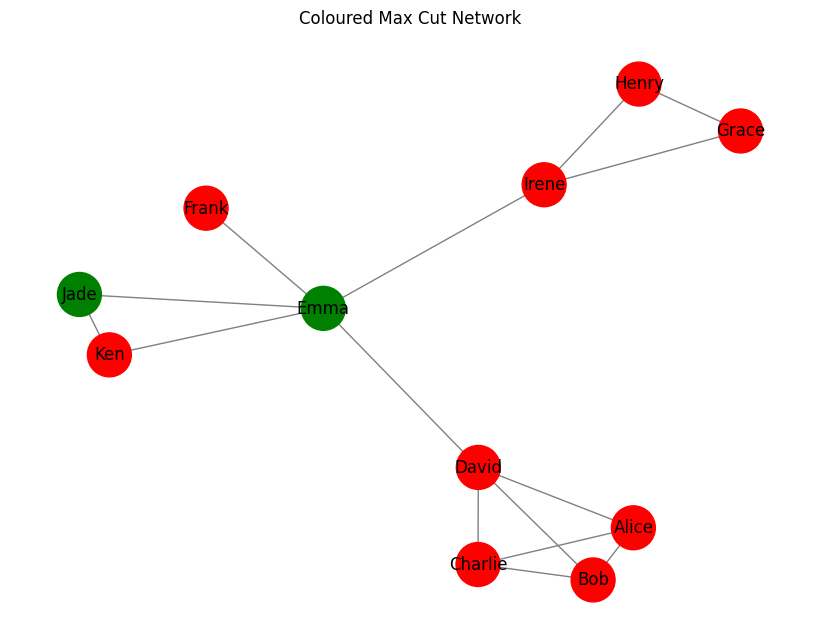

In [15]:

print(best_solution.representation["clique"].keys())
# colour the nodes based on the best result
colours = []
for node in max_clique_graph.nodes:
    if node in best_solution.representation["clique"].keys():
        colours.append("green")
    else:
        colours.append("red")

# Draw the graph with new coloring
plt.figure(figsize=(8, 6))
nx.draw(max_clique_graph, pos, with_labels=True, node_color=colours, edge_color="gray", node_size=1000, font_size=12)
plt.title("Coloured Max Cut Network")
plt.show()

Interpret the result: